# Outliers Detection

The goal of our analysis is to create an algorithm to find outliers in financial data. Outliers will represent members with unusually high costs in the current month.


## Table of Contents
1. [Introduction](#outliers-detection)
2. [Import Libraries and Load Data](#import-libraries-and-load-data)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Feature Selection](#feature-selection)
5. [Outlier Detection](#outliers-detection)
6. [Results](#results)

# Import Libraries and Load Data

Before getting started, we will load the dataset and have it prepared for analysis. We will import necessary libraries as well as load the dataset as a dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import sys
import os

sys.path.append(os.path.abspath('..'))
from src.utils import *

# Load the dataset into a dataframe
customers = pd.read_csv('../data/raw/sfr_test.csv')

# Exploratory Data Analysis

Now that our data is loaded and ready for analysis, we can explore our dataset, clean our data, and gain insight on our data by visualizing important statistics.

## Understanding the Data

In [2]:
# Display a summary of the DataFrame, including column name, non-null values, and their data types
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10530 entries, 0 to 10529
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   member_unique_id     10530 non-null  int64 
 1   gender               10530 non-null  object
 2   dob                  10530 non-null  object
 3   eligible_year        10530 non-null  int64 
 4   eligible_month       10530 non-null  int64 
 5   affiliation_type     10530 non-null  object
 6   pbp_group            10530 non-null  object
 7   plan_name            6606 non-null   object
 8   npi                  10530 non-null  int64 
 9   line_of_business     10530 non-null  object
 10  esrd                 10530 non-null  bool  
 11  hospice              10530 non-null  bool  
 12  ipa_funding          10530 non-null  object
 13  ma_premium           10530 non-null  object
 14  ma_risk_score        10530 non-null  object
 15  mbr_with_rx_rebates  10530 non-null  object
 16  part

In [3]:
# Return the number of rows and columns in the DataFrame
print('\nThe number of rows and columns in the DataFrame: ', customers.shape)


The number of rows and columns in the DataFrame:  (10530, 28)


In [4]:
# List the column labels as an index object
print('\nList the column labels as an index object: \n', customers.columns)


List the column labels as an index object: 
 Index(['member_unique_id', 'gender', 'dob', 'eligible_year', 'eligible_month',
       'affiliation_type', 'pbp_group', 'plan_name', 'npi', 'line_of_business',
       'esrd', 'hospice', 'ipa_funding', 'ma_premium', 'ma_risk_score',
       'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs',
       'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx',
       'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap'],
      dtype='object')


In [5]:
# Return a statistical summary of the DataFrame
print('\nStatistical summary of the DataFrame: \n', customers.describe())


Statistical summary of the DataFrame: 
        member_unique_id  eligible_year  eligible_month           npi
count      10530.000000        10530.0         10530.0  10530.000000
mean        5265.500000         2020.0        202006.0     44.351852
std         3039.893501            0.0             0.0     27.025010
min            1.000000         2020.0        202006.0      1.000000
25%         2633.250000         2020.0        202006.0     21.000000
50%         5265.500000         2020.0        202006.0     40.000000
75%         7897.750000         2020.0        202006.0     68.000000
max        10530.000000         2020.0        202006.0     93.000000


In [6]:
# .head(n): Grabs the first n rows in the dataframe
print(customers.head())

# .tail(n): Grab the bottom n rows in the dataframe
print(customers.tail())

   member_unique_id gender         dob  eligible_year  eligible_month  \
0                 1      F  21/06/1990           2020          202006   
1                 2      M  02/01/1948           2020          202006   
2                 3      M  14/06/1948           2020          202006   
3                 4      M  10/02/1954           2020          202006   
4                 5      M  31/12/1953           2020          202006   

  affiliation_type pbp_group             plan_name  npi line_of_business  ...  \
0        Affiliate   NON-SNP   MEDICARE - CAREFREE    1              HMO  ...   
1        Affiliate   NON-SNP                   NaN    1              HMO  ...   
2        Affiliate   NON-SNP   MEDICARE - CAREFREE    1              HMO  ...   
3        Affiliate     D-SNP  MEDICARE - CARENEEDS    1              HMO  ...   
4        Affiliate   NON-SNP                   NaN    1              HMO  ...   

   pcp_ffs  plan_premium       prof reinsurance risk_score_partd          

## Data Cleaning

Converting financial columns to type float by removing '$' and ','


In [7]:
# Identify financial columns
financial_cols = [col for col in customers.columns if customers[col].dtype == 'object' and customers[col].str.contains(r'\$').any()]
print(financial_cols)

['ipa_funding', 'ma_premium', 'ma_risk_score', 'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs', 'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx', 'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap']


In [8]:
# Remove '$' and ',' from the financial columns and convert them to float
for col in financial_cols:
    customers[col] = customers[col].replace({r'\$': '', ',': ''}, regex=True).astype(float)

print(customers[financial_cols].head())

   ipa_funding  ma_premium  ma_risk_score  mbr_with_rx_rebates  partd_premium  \
0      2721.85     3611.21           2.02               632.13          82.13   
1      5060.21     6817.97           5.24              2535.98         205.93   
2      3159.82     3443.32           3.17               595.96          59.13   
3      9563.23    11015.31           9.92               181.95         265.65   
4     17456.26    17590.58          25.55               810.83         210.62   

   pcp_cap  pcp_ffs  plan_premium    prof  reinsurance  risk_score_partd  \
0   474.83      0.0       3507.00     0.0         7.92               0.0   
1   457.04      0.0       6204.84     0.0         8.13               0.0   
2   482.63      0.0       4012.46     0.0         7.92               0.0   
3   469.04      0.0       9770.61     0.0         8.30               0.0   
4   527.98      0.0      19976.13  8875.8         8.90               0.0   

         rx  rx_rebates  rx_with_rebates  rx_without_reb

Convert Date of Birth (dob) to datetime and create a new column called age

In [9]:
# Convert dob column to datetime 
customers['dob'] = pd.to_datetime(customers['dob'],dayfirst=True)

# Create a new column called 'age'
customers['age'] = (pd.to_datetime('now') - customers['dob']).dt.days // 365

print(customers[['dob', 'age']].head())

         dob  age
0 1990-06-21   34
1 1948-01-02   77
2 1948-06-14   76
3 1954-02-10   71
4 1953-12-31   71


Handling missing values

In [10]:
# Returns True if any value in the series is null
print(customers.columns[customers.isna().any()])

# Find rows where their "plan_name" is null
customers[customers["plan_name"].isna()]

Index(['plan_name'], dtype='object')


,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,...,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap,age
1,2,M,1948-01-02,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,6204.84,0.0,8.13,0.0,11289.69,0.0,10688.46,10859.82,906.77,77
4,5,M,1953-12-31,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,19976.13,8875.8,8.90,0.0,522.48,0.0,517.56,606.01,867.55,71
8,9,F,1949-07-22,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,12942.04,0.0,8.32,0.0,0.00,0.0,0.00,0.00,823.63,75
10,11,F,1951-01-01,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,6788.10,0.0,8.44,0.0,0.00,0.0,0.00,0.00,836.41,74
16,17,M,1953-05-20,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,...,9071.13,0.0,9.19,0.0,145.61,0.0,146.34,140.15,786.09,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10521,10522,M,1962-04-19,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,11868.16,0.0,8.18,0.0,679.59,0.0,707.11,672.21,875.47,62
10524,10525,F,1955-09-04,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,28682.90,0.0,9.36,0.0,387.05,0.0,335.54,362.33,923.96,69
10525,10526,F,1954-04-07,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,5097.30,0.0,8.94,0.0,317.71,0.0,292.58,279.22,989.74,70
10526,10527,F,1945-12-08,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,...,11278.18,0.0,8.93,0.0,238.86,0.0,234.95,248.51,1002.72,79


Would plan_name be useful for outlier detection? We can fill the missing values with 'Unknown' since the null rows within it are a big portion of our data.

In [11]:
# Replace missing values in the "plan_name" column with "Unknown"
customers.fillna({'plan_name': 'Unknown'}, inplace = True)
print(f'Missing values in plan_name: {customers["plan_name"].isna().sum()}')

Missing values in plan_name: 0


Convert categorical variables to category type

In [12]:
# Convert categorical columns to category data type
categorical_cols = ['gender', 'affiliation_type', 'pbp_group', 'plan_name', 'line_of_business']
for col in categorical_cols:
    customers[col] = customers[col].astype('category')

# Display the data types of the columns
print(customers[categorical_cols].dtypes)

gender              category
affiliation_type    category
pbp_group           category
plan_name           category
line_of_business    category
dtype: object


## Feature Selection

Verify financial columns are correctly converted

In [13]:
print(customers[financial_cols].dtypes)  # Should all be float64


ipa_funding            float64
ma_premium             float64
ma_risk_score          float64
mbr_with_rx_rebates    float64
partd_premium          float64
pcp_cap                float64
pcp_ffs                float64
plan_premium           float64
prof                   float64
reinsurance            float64
risk_score_partd       float64
rx                     float64
rx_rebates             float64
rx_with_rebates        float64
rx_without_rebates     float64
spec_cap               float64
dtype: object


Naively identifying extreme values

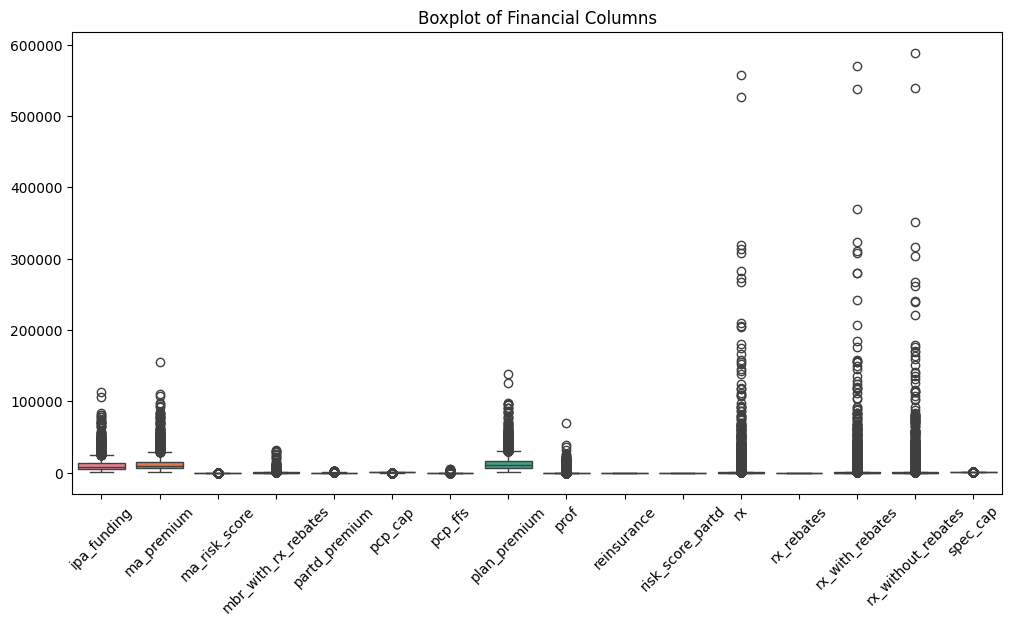

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=customers[financial_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Financial Columns")
plt.show()

Columns with extreme outliers
- rx, rx_rebates, rx_with_rebates, rx_without_rebates, plan_premium, ipa_funding, ma_premium

Columns with minimal variation
- ma_risk_score, partd_premium, pcp_cap, pcp_ffs, reinsurance, risk_score_partd, rx_rebates, spec_cap

Applying IQR filtering to columns with extreme outliers

### New Features
`rx_to_premium = rx/plan_premium`
    - detects members spending way more on perscriptions than expected

`funding_to_premium = ipa_funding/plan_premium`
    - High values may indicate overfunding or unusual financial structures

`ma_premium_share = ma_premium/plan_premium`
    - Help detect members with disproportionate premium contributions
    
`rebate_savings = rx_without_rebates/rx_with_rebates`
    - members with low rebates might be flagged for investigation

`payment_to_age = plan_premium/age`
    - Members might be paying more/less based on how old they are

In [15]:
# Implementing new features into customers dataframe
customers["rx_to_premium"] = customers["rx"] / (customers["plan_premium"] + 1e-5)
customers["funding_to_premium"] = customers["ipa_funding"] / (customers["plan_premium"] + 1e-5)
customers["ma_premium_share"] = customers["ma_premium"] / (customers["plan_premium"] + 1e-5)
customers["rebate_savings"] = (customers["rx_without_rebates"] - customers["rx_with_rebates"]) / (customers["rx_without_rebates"] + 1e-5)
customers["payment_to_age"] = customers["plan_premium"] / (customers["age"] + 1e-5)

Add new ratios to financial_cols

In [16]:
financial_cols.extend(["rx_to_premium", "funding_to_premium", "ma_premium_share", "rebate_savings", "payment_to_age"])

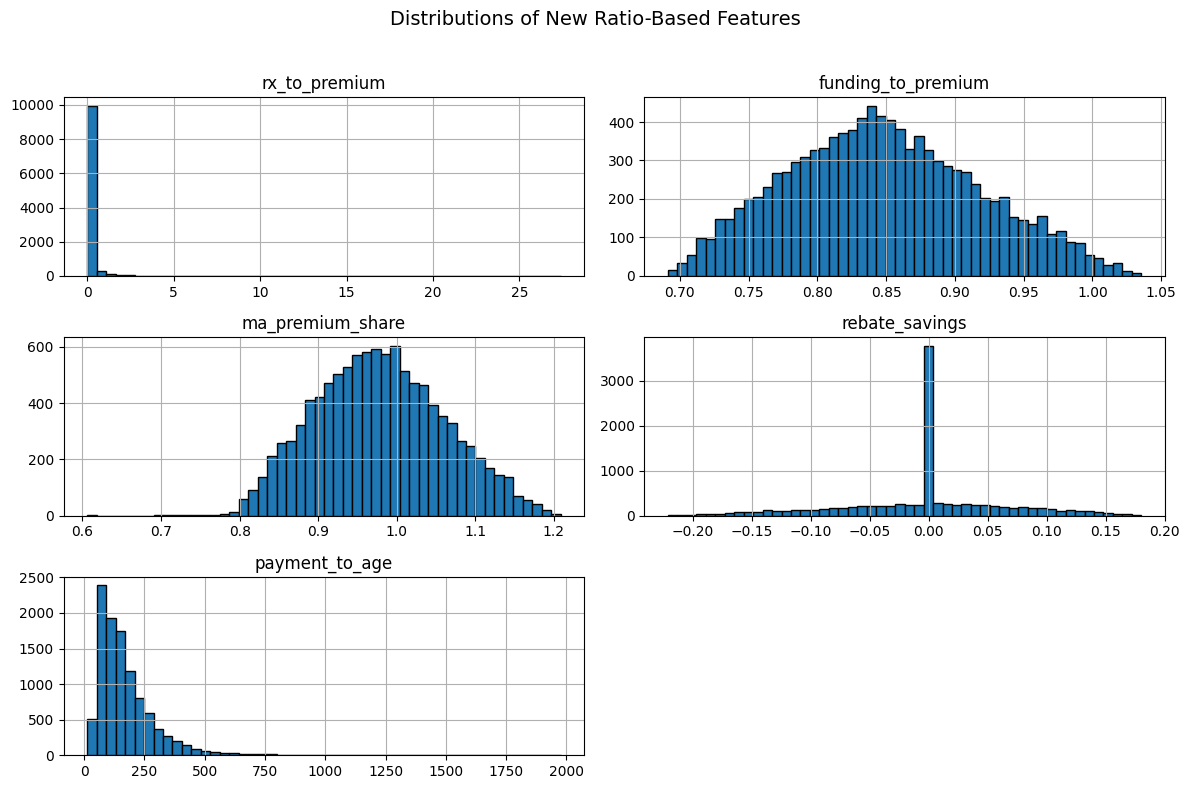

In [17]:
customers[["rx_to_premium", "funding_to_premium", "ma_premium_share", "rebate_savings", "payment_to_age"]].hist(
    bins=50, figsize=(12, 8), layout=(3, 2), edgecolor="black"
)
plt.suptitle("Distributions of New Ratio-Based Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Outlier Detection


Financial Columns

In [18]:
print(financial_cols)

['ipa_funding', 'ma_premium', 'ma_risk_score', 'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs', 'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx', 'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap', 'rx_to_premium', 'funding_to_premium', 'ma_premium_share', 'rebate_savings', 'payment_to_age']


### IQR Outlier Detection

In [19]:
# Use IQR function from src/utils.py
iqr_outliers = iqr_outlier_detection(customers, financial_cols)
print(iqr_outliers)

Column: ipa_funding   |   Outliers: 468
Column: ma_premium   |   Outliers: 473
Column: ma_risk_score   |   Outliers: 455
Column: mbr_with_rx_rebates   |   Outliers: 787
Column: partd_premium   |   Outliers: 521
Column: pcp_cap   |   Outliers: 2182
Column: pcp_ffs   |   Outliers: 417
Column: plan_premium   |   Outliers: 483
Column: prof   |   Outliers: 1847
Column: reinsurance   |   Outliers: 0
Column: risk_score_partd   |   Outliers: 0
Column: rx   |   Outliers: 1621
Column: rx_rebates   |   Outliers: 0
Column: rx_with_rebates   |   Outliers: 1625
Column: rx_without_rebates   |   Outliers: 1619
Column: spec_cap   |   Outliers: 182
Column: rx_to_premium   |   Outliers: 1551
Column: funding_to_premium   |   Outliers: 0
Column: ma_premium_share   |   Outliers: 6
Column: rebate_savings   |   Outliers: 1480
Column: payment_to_age   |   Outliers: 510
{'ipa_funding': [26040.0, 43965.67, 32605.21, 27481.67, 30525.51, 37149.57, 34550.67, 26784.01, 30349.25, 36259.82, 37585.26, 29912.23, 51750.3

#### IQR BoxPlot

### LOF Outlier Detection

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. 

In [ ]:
# Use LOF function from src/utils.py and output list of members as outliers
lof_outliers = lof_outlier_detection(customers, financial_cols)

outlier_df = customers.iloc[lof_outliers]
print(outlier_df)

Total outliers detected: 527
       member_unique_id gender        dob  eligible_year  eligible_month  \
21                   22      M 1953-07-28           2020          202006   
62                   63      M 1944-06-29           2020          202006   
71                   72      F 1951-04-30           2020          202006   
73                   74      F 1954-06-06           2020          202006   
96                   97      M 1946-11-18           2020          202006   
...                 ...    ...        ...            ...             ...   
10457             10458      F 1953-06-07           2020          202006   
10493             10494      M 1947-10-05           2020          202006   
10496             10497      F 1959-04-12           2020          202006   
10501             10502      F 1948-04-11           2020          202006   
10502             10503      F 1965-10-08           2020          202006   

      affiliation_type pbp_group             plan_name  np

#### LOF Scatter  PLot

### Isolation Forest Outlier Detection

In [23]:
# Use Isolation Forest function from src/utils.py
iso_outliers = iso_forest_outlier_detection(customers, financial_cols)  # NOT WORKING PROPERLY
iso_outliers_df = customers.iloc[iso_outliers]
print(iso_outliers_df)

Total Outliers: 527
       member_unique_id gender        dob  eligible_year  eligible_month  \
62                   63      M 1944-06-29           2020          202006   
107                 108      M 1956-05-18           2020          202006   
122                 123      M 1960-06-30           2020          202006   
130                 131      F 1968-03-07           2020          202006   
167                 168      M 1959-08-01           2020          202006   
...                 ...    ...        ...            ...             ...   
10446             10447      M 1939-09-05           2020          202006   
10452             10453      F 1944-06-24           2020          202006   
10453             10454      F 1974-07-04           2020          202006   
10464             10465      F 1952-11-15           2020          202006   
10467             10468      M 1962-11-27           2020          202006   

      affiliation_type pbp_group             plan_name  npi line_of

#### Isolation Forest Scatter Plot

### Combination of the 3 Outlier Methods

In [22]:
# Find overlapping outlier rows 

#### Combination of Outlier Methods Box Plot

# Results

